# Defining Complex Charge Dependence in ECMs
Many parameters in equivalent circuit models (ECMs) depend on how charged the battery is.
The most common example is that the voltage of a cell increases with the state of charge (SOC). 
Moirae provides several routes to expressing the SOC dependence for different properties

## Interpolated SOC Dependence
Define a complex dependence on SOC using `SOCInterpolatedHealth`

In [1]:
from moirae.models.ecm.utils import SOCInterpolatedHealth, realistic_fake_ocv
import numpy as np

This function takes the values of the property at specific states of charge.

In [2]:
soc = np.linspace(0, 1, 9) 
points = realistic_fake_ocv(soc)

Supply both the value of the function (``base_values``) and, optionally, the points at which they are evaluated.

> Moirae assumes evenly-spaced SOC points between 0 and 1 by default.

In [3]:
ocv = SOCInterpolatedHealth(
    base_values=points,
    soc_pinpoints=soc,
    interpolation_style='linear',
)

Text(0.5, 0, 'SOC')

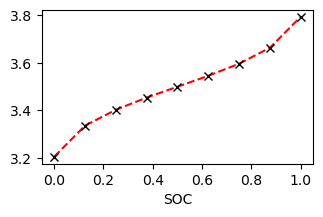

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(3.5, 2.))

# Evaluate the function
#  Always returns a 3D array. First two are batch sizes, last is the property
value = ocv.get_value(soc)[0, 0, :]
ax.plot(soc, value, 'r--')
ax.plot(soc, points, 'kx')

ax.set_xlabel('SOC')

### Interpolation with Polynomial Scaling
Interpolation functions can capture complex function shapes, at the expense of many fitting parameters.

The ``ScaledSOCInterpolatedHealth`` keep can keep the complex shapes of interpolated functions
and instead a few "scaling" parameters that describe small changes to the shape.

Use the ``ScaledSOCInterpolatedHealth`` to define SOC dependence in two layers:
- ``base_values``, ``soc_points``: The base shape of the functional dependence
- ``scaling_coeffs``: Parameters of a [Legendre polynomial](https://en.m.wikipedia.org/wiki/Legendre_polynomials) used to adjust the shape.

> Aside: Legendre Polynomials are good for interpolation because each polynomial is orthogonal to all others)

In [5]:
from moirae.models.ecm.utils import ScaledSOCInterpolatedHealth

The interpolated curve is unchanged if all scaling parameters are zero.
The first parameter introduces the same change to all points, 
the second adds a linear dependence to SOC, the third a quadratic, and so on.

In [6]:
ocv = ScaledSOCInterpolatedHealth(
    base_values=points,
    scaling_coeffs=[0., 0., 0.]
)

Evaluate with a few changes

In [7]:
scaled_allzero = ocv.get_value(soc)[0, 0, :]

In [8]:
ocv.scaling_coeffs[0, 0] = 0.05
scaled_constant = ocv.get_value(soc)[0, 0, :]

In [9]:
ocv.scaling_coeffs[0, :2] = [0., 0.1]
scaled_linear = ocv.get_value(soc)[0, 0, :]

In [10]:
ocv.scaling_coeffs[0, 1:] = [0, 0.1]
scaled_quadra = ocv.get_value(soc)[0, 0, :]

Text(0.5, 0, 'SOC')

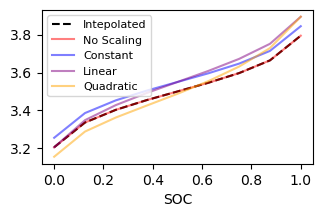

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

# Evaluate the function
#  Always returns a 3D array. First two are batch sizes, last is the property
ax.plot(soc, value, 'k--', label='Intepolated')
ax.plot(soc, scaled_allzero, 'r', label='No Scaling', alpha=0.5)
ax.plot(soc, scaled_constant, 'b', label='Constant', alpha=0.5)
ax.plot(soc, scaled_linear, color='purple', label='Linear', alpha=0.5)
ax.plot(soc, scaled_quadra, color='orange', label='Quadratic', alpha=0.5)

ax.legend(fontsize=8)
ax.set_xlabel('SOC')

Estimators could adjust the slightly by fitting 3 `ocv.scaling_coeffs` instead of fitting all 9 `ocv.base_values` points.

## Advanced: Batching and SOC Dependence
Moirae estimators guess batches of parameter values that may include both multiple values for interpolation points and multiple values of SOC.
The SOC dependence classes treat parameters describing the functional dependence and SOC values separately.
As a result, the output for an SOC class is 3 dimensional: "batch size of function parameters" x "batch size of SOC" x "number of SOC points in each batch"

In [12]:
help(ocv.get_value)

Help on method get_value in module moirae.models.ecm.utils:

get_value(soc: Union[numbers.Number, List, numpy.ndarray]) -> numpy.ndarray method of moirae.models.ecm.utils.ScaledSOCInterpolatedHealth instance
    Computes value(s) at given SOC(s).
    
    This function always returns a 3D array, of shape `(internal_batch_size, soc_batch_size, soc_dim)`, where
    `internal_batch_size` is the batch size of the underlying health variable, `soc_batch_size` is the batch size
    of the SOC array, and `soc_dim` is the dimensionality of the SOC. The SOC must be passed as either:
    1. a 2D array of shape `(soc_batch_size, soc_dim)`
    2. a 1D array of shape `(soc_dim,)`, in which case we will consider the `soc_batch_size` to be equal to 1
    3. a 0D array (that is, a numer), in which case both `soc_batch_size` and `soc_dim` are equal to 1.
    
    Args:
        soc: Values at which to compute the property
    Returns:
        Interpolated values as a 3D with dimensions (batch_size, soc_b

Provide multiple guesses for scaling points will affect the first point.

In [13]:
ocv.scaling_coeffs = np.array([[0., 0.], [0.01, 0.01]])

In [14]:
outputs = ocv.get_value(soc)
outputs.shape

(2, 1, 9)

The array is 2 (batch size of parameter functions) x 1 (batch size of SOC inputs) x 9 (number of SOC points in the evaluation)

Text(0.5, 0, 'SOC')

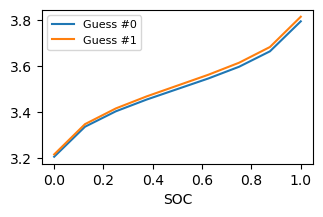

In [15]:
fig, ax = plt.subplots(figsize=(3.5, 2))

for i, y in enumerate(outputs[:, 0, :]):
    ax.plot(soc, y, label=f'Guess #{i}')

ax.legend(fontsize=8)
ax.set_xlabel('SOC')

Each member of the output batch is with a different value of parameters